In [23]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import torch.optim
import numpy as np
from sklearn.cluster import KMeans

## 1 Generative modeling

### 1.1 Implementation of GAN

In [28]:
p1_data = pd.read_pickle("./hw5_p1.pkl")
p1_data = torch.tensor(p1_data, dtype=torch.float32)
p1_data.shape

/var/folders/jw/6cygsm496qs9d6kbsmmwmnrc0000gn/T/ipykernel_66647/304156660.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p1_data = torch.tensor(p1_data, dtype=torch.float32)


torch.Size([2000, 2])

In [29]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2))

    def forward(self, x):
        out = self.network(x)
        return out

In [30]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.network(x)
        return out

In [31]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)
desc_opt = torch.optim.Adam(discriminator.parameters(), lr=1e-4)


In [33]:
def gan_training():
    for epoch in range(10000):
        for _ in range(10):
            z = torch.randn((128, 2), device=device)
            fake = generator(z)
            real = p1_data[torch.randint(0, len(p1_data), (128,))].to(device)

            pred_real = discriminator(real)
            pred_fake = discriminator(fake.detach())

            desc_loss = -torch.mean(torch.log(pred_real) + torch.log(1 - pred_fake))

            desc_opt.zero_grad()
            desc_loss.backward()
            desc_opt.step()

        z = torch.randn((128, 2), device=device)
        fake = generator(z)
        pred_fake = discriminator(fake)
        gen_loss = -torch.mean(torch.log(pred_fake + 1e-8))

        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()

        print(f"Epoch {epoch}: Loss_D={desc_loss.item():.4f}, Loss_G={gen_loss.item():.4f}")

In [34]:
gan_training()

Epoch 0: Loss_D=1.2160, Loss_G=0.6735
Epoch 1: Loss_D=1.0933, Loss_G=0.6757
Epoch 2: Loss_D=0.9990, Loss_G=0.6816
Epoch 3: Loss_D=0.9621, Loss_G=0.6920
Epoch 4: Loss_D=0.8904, Loss_G=0.7058
Epoch 5: Loss_D=0.8489, Loss_G=0.7251
Epoch 6: Loss_D=0.8023, Loss_G=0.7425
Epoch 7: Loss_D=0.7649, Loss_G=0.7627
Epoch 8: Loss_D=0.7316, Loss_G=0.7861
Epoch 9: Loss_D=0.7210, Loss_G=0.8082
Epoch 10: Loss_D=0.6897, Loss_G=0.8334
Epoch 11: Loss_D=0.6645, Loss_G=0.8649
Epoch 12: Loss_D=0.6262, Loss_G=0.8899
Epoch 13: Loss_D=0.6163, Loss_G=0.9080
Epoch 14: Loss_D=0.5804, Loss_G=0.9451
Epoch 15: Loss_D=0.5679, Loss_G=0.9719
Epoch 16: Loss_D=0.5339, Loss_G=1.0030
Epoch 17: Loss_D=0.5334, Loss_G=1.0355
Epoch 18: Loss_D=0.5019, Loss_G=1.0648
Epoch 19: Loss_D=0.4889, Loss_G=1.0870
Epoch 20: Loss_D=0.4612, Loss_G=1.1311
Epoch 21: Loss_D=0.4364, Loss_G=1.1605
Epoch 22: Loss_D=0.4230, Loss_G=1.1918
Epoch 23: Loss_D=0.4039, Loss_G=1.2410
Epoch 24: Loss_D=0.3999, Loss_G=1.2616
Epoch 25: Loss_D=0.3906, Loss_G=1.3

### 1.2 Discriminator’s output

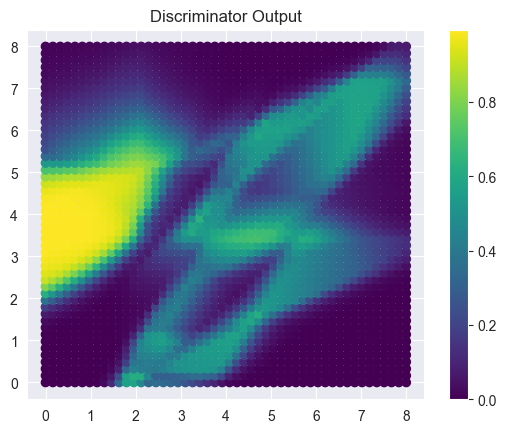

In [37]:
X, Y = torch.meshgrid(torch.linspace(0, 8, 50), torch.linspace(0, 8, 50))
xgrid = torch.stack([X.reshape(-1), Y.reshape(-1)], 1)
discGrid = discriminator(xgrid.to(device=device))
discGrid = discGrid.detach().cpu().numpy()

plt.scatter(xgrid[:, 0], xgrid[:, 1], c=discGrid, cmap='viridis')
plt.title('Discriminator Output')
plt.colorbar()
plt.show()


### 1.3 Generator’s output

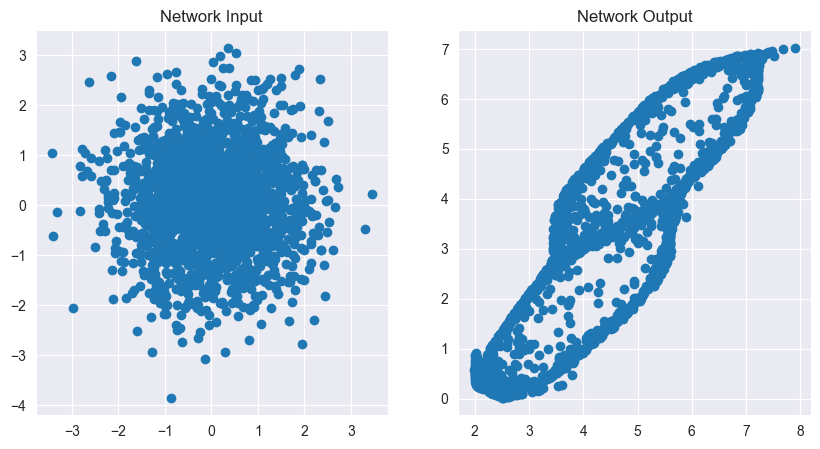

In [36]:
z = torch.randn((2000, 2))
xhat = generator(z.to(device=device)).detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(z[:, 0], z[:, 1])
ax[0].set_title('Network Input')

ax[1].scatter(xhat[:, 0], xhat[:, 1])
ax[1].set_title('Network Output')
plt.show()

## 2 Spectral Clustering

In [16]:
p2_data = pd.read_pickle("./hw5_p2.pkl")
p2_data.shape

(999, 2)

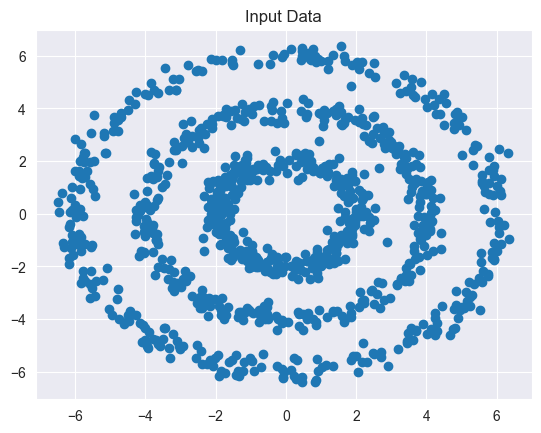

In [39]:
X = np.array(p2_data)
N = X.shape[0]

plt.scatter(X[:, 0], X[:, 1])
plt.title("Input Data")
plt.show()

In [ ]:
def rbf_kernel(x, y, sigma=0.2):
    diff = np.linalg.norm(x - y)
    return np.exp(-diff**2 / (2 * sigma**2))

### 2.2 Spectral clustering algorithm

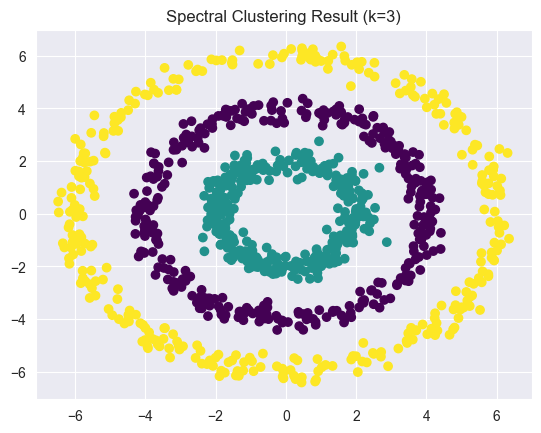

In [43]:
W = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        W[i, j] = rbf_kernel(X[i], X[j])

D = np.diag(W.sum(axis=1))
L = D - W
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
L_sym = D_inv_sqrt @ L @ D_inv_sqrt

eigvals, eigvecs = np.linalg.eigh(L_sym)
idx = np.argsort(eigvals)
eigvecs = eigvecs[:, idx]
U = eigvecs[:, :3]


kmeans = KMeans(n_clusters=3, n_init=20)
labels_spec = kmeans.fit_predict(U)

plt.scatter(X[:, 0], X[:, 1], c=labels_spec, cmap='viridis')
plt.title("Spectral Clustering Result (k=3)")
plt.show()

### 2.3 Compare to K-Means

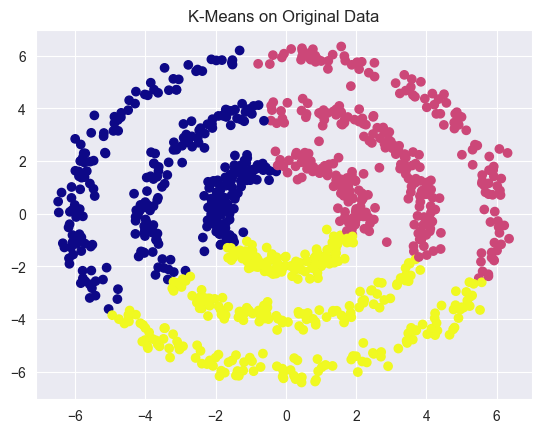

In [41]:
kmeans_raw = KMeans(n_clusters=3, n_init=20)
labels_raw = kmeans_raw.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels_raw, cmap='plasma')
plt.title("K-Means on Original Data")
plt.show()